<a href="https://colab.research.google.com/github/spoupry/spoupry/blob/main/Aggregators_algorithm_export_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import librairy

In [1]:
import pandas as pd
from pathlib import Path
import os.path
import numpy as np 
import matplotlib.pyplot as plt
from statsmodels.nonparametric.kernel_regression import KernelReg
# For parsing dates
from datetime import datetime, timedelta
from dateutil.parser import parse

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Import data

From google drive

In [ ]:
# Import data from drive
# from google.colab import drive
# drive.mount('/content/drive')
# dir_path = '/content/drive/My Drive/Colab Notebooks/'

# Read and use csv file
# Daily PM10
# df = pd.read_csv(dir_path + "pm10_daily.csv", delimiter="\t")
# print(df.head(2))

From GitHub

In [2]:
# # Import data from GitHub
url = 'https://raw.githubusercontent.com/spoupry/spoupry/main/pm10_daily.csv'
# # Read and use csv file
# # Daily PM10
df = pd.read_csv(url, delimiter="\t")

# # Import data from GitHub
# url = 'https://raw.githubusercontent.com/spoupry/spoupry/main/humidite.csv'
# # Read and use csv file
# # Random csv from online website
# df = pd.read_csv(url, delimiter=";",decimal=",")
# # remplacement de la virgule par un point 


print(df.head(10))
df.dtypes

           DateTime  Arg12b1f  ENI0122B1V1  ENI0122B2V1
0  03/02/2022 08:22       NaN         35.7         42.8
1  03/02/2022 08:22      36.2          NaN          NaN
2  03/02/2022 08:27      31.0         29.9          0.0
3  03/02/2022 08:32      20.0          NaN          NaN
4  03/02/2022 08:32       NaN         18.2          NaN
5  03/02/2022 08:32       NaN          NaN         24.0
6  03/02/2022 08:37      15.9          NaN          NaN
7  03/02/2022 08:37       NaN          NaN         16.2
8  03/02/2022 08:37       NaN         18.2          NaN
9  03/02/2022 08:42      15.9          NaN          NaN


DateTime        object
Arg12b1f       float64
ENI0122B1V1    float64
ENI0122B2V1    float64
dtype: object

# Loading database and parse data as columns index

In [3]:
# Parse date
df["DateTime"] = pd.to_datetime(df["DateTime"]) 
# df.head(2)
# Initialization dataset
# Setting the timestamp as dataframe's index. 
df.set_index('DateTime', inplace=True) # DateTime is now the index. 
print(df.head(10))
df.dtypes

                     Arg12b1f  ENI0122B1V1  ENI0122B2V1
DateTime                                               
2022-03-02 08:22:00       NaN         35.7         42.8
2022-03-02 08:22:00      36.2          NaN          NaN
2022-03-02 08:27:00      31.0         29.9          0.0
2022-03-02 08:32:00      20.0          NaN          NaN
2022-03-02 08:32:00       NaN         18.2          NaN
2022-03-02 08:32:00       NaN          NaN         24.0
2022-03-02 08:37:00      15.9          NaN          NaN
2022-03-02 08:37:00       NaN          NaN         16.2
2022-03-02 08:37:00       NaN         18.2          NaN
2022-03-02 08:42:00      15.9          NaN          NaN


Arg12b1f       float64
ENI0122B1V1    float64
ENI0122B2V1    float64
dtype: object

# Initialisation

In [4]:
# Initialization variables
StartTime_df = df.index[0]  # Starting timestamp dataset
EndTime_df = df.index[-1]   # End timestamp dataset
tau = timedelta(minutes=30) # step size for rolling window
StepTime = StartTime_df + tau  # time's slice
Threshold = 30 #  35% bonds for outliers
# Time-series for raw datas for graphics
X1raw = pd.Series( [0] , index = [StartTime_df], dtype=float) 
X2raw = pd.Series( [0] , index = [StartTime_df], dtype=float)
X3raw = pd.Series( [0] , index = [StartTime_df], dtype=float)
# print("Start df",StartTime_df,"End df",EndTime_df,"step",StepTime)
# Initialise global series (4)
# Median for row datas
Median = pd.DataFrame(index = [StartTime_df], columns=['Median','MedMax','MedMin'],dtype=float)
# Output time-serie after median voter
Outagg = pd.Series([0], index = [StartTime_df], dtype=float)
# Alert time-series from no data detection
Alert = pd.Series( ['Begin'] , index = [StartTime_df])
# Outliers time-series corresponding SmS
X1out = pd.Series( [0] , index = [StartTime_df], dtype=float)
X2out = pd.Series( [0] , index = [StartTime_df], dtype=float)
X3out = pd.Series( [0] , index = [StartTime_df], dtype=float)
# Reliable time-series extracted from Median 
X1r = pd.Series( [0] , index = [StartTime_df], dtype=float)
X2r = pd.Series( [0] , index = [StartTime_df], dtype=float)
X3r = pd.Series( [0] , index = [StartTime_df], dtype=float)

# Functions

In [5]:
# Calculate the median of a time-serie
# Input : time-serie
# Output the median as a float or None if list =[]
def calculate_median(l):
    l = sorted(l)
    l_len = len(l)
    if l_len < 1:
        return None
    if l_len % 2 == 0 :
        return ( l[(l_len)//2] + l[(l_len//2)-1] ) / 2.0
    else:
        return l[(l_len-1)//2]

In [6]:
# Dectect Hardware fault
# Input: 3 time-serie of a slice
# No Output 
# Store data in Alert global time-series
def detect_no_data(X1,X2,X3):
    # Detection no Data
    # print("Start detection hardware fault")
    HardwareFault=[]
    # print("size of time-series X1,X2,X3 =",len(X1),len(X2),len(X3))
    if (len(X1) == 0): 
      # print("Hardware fault SmS1")
      HardwareFault.append("Hardware Fault SmS1")
    if (len(X2) == 0): 
      # print("Hardware fault SmS2")
      HardwareFault.append("Hardware Fault SmS2")
    if (len(X3) == 0): 
      # print("Hardware fault SmS3")
      HardwareFault.append("Hardware Fault SmS3")
    if (len(HardwareFault) == 0):
      print("All sensors is ok")
    else:
      print(HardwareFault," Ic= ", 3 - len(Alert.loc[StepTime]),"/3")     
    # Store Hardware fault in Alert time-serie
    Alert.loc[StepTime] = HardwareFault
    # print("End detection hardware fault")

In [7]:
# Dectect outlier from median and threshold
# Input: 3 time-series of a slice and a concatenated list of 3
# Output 3 time-series Xrl of reliable values for filtering
# Store in Xr global time-series for later processing
def detect_outliers(X1,X2,X3,Concat):
    # print("Start ouliers detection & store")
    # Evaluate median
    Median_slice = calculate_median(Concat)
    # Calculate MedMax and MedMin for outlier detection
    # print(calculate_median(Concat))
    MedMin = Median_slice - (Median_slice*Threshold)/100
    MedMax = Median_slice + (Median_slice*Threshold)/100
    # Store median for graphics in Median time-series
    Median.loc[StepTime,'Median'] = Median_slice 
    Median.loc[StepTime,'MedMin'] = MedMin 
    Median.loc[StepTime,'MedMax'] = MedMax 
    # print("Median",Median_slice,"MedMin",MedMin,"MedMax",MedMax)
    # Outputs function: X reliable data time-series
    X1rl = [] 
    X2rl = []
    X3rl = []
    idx_1rl= []      
    idx_2rl= [] 
    idx_3rl= [] 
    # Outliers and reliable of X1
    if(len(X1) != 0):     
      for time, row in X1.iteritems():
        if((row > MedMax) or (row < MedMin)):
          X1out.loc[time] = row 
        else:
          #store in global X1r time-serie for graphics
          X1r.loc[time] = row 
          X1rl.append(row)    
          idx_1rl.append(time)
    # print(X1)
    # print(X1out)
    # print(X1r)
    # Outliers and reliable of X2
    if(len(X2) != 0):
      for time, row in X2.iteritems():
          if((row > MedMax) or (row < MedMin)):
            X2out.loc[time] = row 
          else:
            #store in global X1r time-serie for graphics
            X2r.loc[time] = row 
            X2rl.append(row)   
            idx_2rl.append(time)
    # print(X2)
    # print(X2out)
    # print(X2r)
    # Outliers and reliable of X3
    if(len(X3) != 0):
      for time, row in X3.iteritems():
        if((row > MedMax) or (row < MedMin)):
          X3out.loc[time] = row 
        else:
          #store in global X1r time-serie for graphics
          X3r.loc[time] = row 
          X3rl.append(row)   
          idx_3rl.append(time)
    # print(X3)
    # print(X3out)
    # print(X3r)
    # Construct time-series from lists
    X1rl = pd.Series(X1rl, index = idx_1rl, dtype=float)
    X2rl = pd.Series(X2rl, index = idx_2rl, dtype=float)
    X3rl = pd.Series(X3rl, index = idx_3rl, dtype=float)
    # print("End outliers detection & store")
    return X1rl,X2rl,X3rl

In [8]:
# Smoothing curve by apply kerbel regression
# Input: 3 time-series Xrl of reliable values
# Output 3 time-series Xf filtrated for median voter
def filtering(X1,X2,X3):
  from numpy import linspace
  # print("Start filtering")
  # X1
  # Must have two points minimum
  if(len(X1) == 0 or len(X1) == 1):
    X1f = X1
    print("not enough data")
  else:
    X1_ = X1.copy()
    X1_.index = linspace(1., len(X1_),len(X1_))
    kr = KernelReg([X1_.values],[X1_.index.values], var_type='c')
    f1 = kr.fit([X1_.index.values])
    X1f = pd.Series(data=f1[0], index = X1.index, dtype=float)
  # X2
  # Must have two points minimum
  if(len(X2) == 0 or len(X2) == 1):
    X2f = X2
    print("not enough data")
  else:    
    X2_ = X2.copy()
    X2_.index = linspace(1., len(X2_),len(X2_))
    kr = KernelReg([X2_.values],[X2_.index.values], var_type='c')
    f2 = kr.fit([X2_.index.values])
    X2f = pd.Series(data=f2[0], index = X2.index, dtype=float)
  # X3
  # Must have two points minimum
  if(len(X3) == 0 or len(X3) ==1):
    X3f = X3
    print("not enough data")
  else:
    X3_ = X3.copy()
    X3_.index = linspace(1., len(X3_),len(X3_))
    kr = KernelReg([X3_.values],[X3_.index.values], var_type='c')
    f3 = kr.fit([X3_.index.values])
    X3f = pd.Series(data=f3[0], index = X3.index, dtype=float) 
  # print("End filtering")
  # Return filtered data time-series
  return X1f,X2f,X3f


In [9]:
# Algorithm of the median voter
# Input : 3 time-series reliable and filtered
# Output the synthesis as a float or None if list =[]
def Median_voter(X1,X2,X3):
  # print("Start Median Voter")
  concatenated_series=pd.concat([X1,X2,X3])
  # print(concatenated_series)
  Output = calculate_median(concatenated_series)
  # print("Output=",Output)
  # print("End Median Voter")
  # Return synthesis of median voter
  return Output

In [10]:
# Create X time-series in the rolling window in a tau size from dataset
# Input: a slice of dataset 
# Store in global series Outagg, Xraw
def processing(df):
    print("Start processing slice")
    #create X1,X2,X3 series   
    X1 = [] 
    X2 = []
    X3 = []
    idx_1= []       # lists for Xi time series creation
    idx_2= [] 
    idx_3= [] 
    for time, row in df.iterrows():
      if(pd.isna(row[df.columns[0]]) == False ): # NaN detection 
        X1.append(row[df.columns[0]])            # stock in x1 list
        idx_1.append(time)
        X1raw.loc[time] = row[df.columns[0]]     # input in X1raw time-serie
      if(pd.isna(row[df.columns[1]]) == False ): 
        X2.append(row[df.columns[1]]) 
        idx_2.append(time)
        X2raw.loc[time] = row[df.columns[1]]     # input in X2raw time-serie            
      if(pd.isna(row[df.columns[2]]) == False ):
        X3.append(row[df.columns[2]])
        idx_3.append(time)
        X3raw.loc[time] = row[df.columns[2]]     # input in X3raw time-serie
    # print(X1,X2,X3)
    # Concatenation of all elements of the rolling windows
    Concat = X1 + X2 + X3
    # Create time series             
    X1 = pd.Series(X1, index = idx_1, dtype=float)
    X2 = pd.Series(X2, index = idx_2, dtype=float)
    X3 = pd.Series(X3, index = idx_3, dtype=float)
    # print("X1,X2 and X3 created")
    # Function detection hardware fault
    detect_no_data(X1,X2,X3)
    # Function detection outliers + stock values in Xout series 
    Xreliable = detect_outliers(X1,X2,X3,Concat) # return reliable data (Xr)
    # print(Xreliable)
    # Function kernel regression return filtered data (Xrf)
    Xfiltered = filtering(Xreliable[0],Xreliable[1],Xreliable[2])
    # Function Median voter
    Output = Median_voter(Xfiltered[0],Xfiltered[1],Xfiltered[2])
    # Store ouput in the Outagg time-series
    if(Output == None): 
      print("oh la la")
    else:
      Outagg.loc[StepTime] = Output
    #return X1,X2,X3

# Main algorithm


First slice of database

In [11]:
# Initialise the first slice by read first Timestamps from dataset
# Create the firts slice of dataset for processing
# First slice of time from df dataframe
StepTime = StartTime_df + tau
Time_slice_list=[StartTime_df ]
print("Start: ", StartTime_df, " , End: ", StepTime)
# Identificate the first slice
df_slice = df.loc[StartTime_df:StepTime].copy()
# Processing slice
processing(df_slice)
Median.loc[StartTime_df] = Median.loc[StepTime]
# print(Median)
# Sometimes a message appear : KeyError: Timestamps it due to tau parameters that is too small for the numbers of data collecter in Xseries

Start:  2022-03-02 08:22:00  , End:  2022-03-02 08:52:00
Start processing slice
All sensors is ok


Others slices until the end of database

In [12]:
# Rolling window throught the dataset
# Others slices
for time, row in df.iterrows():
  if(time <= StepTime):
    This_time = time
    #print(time)  
  if(time > StepTime):
    Start_step = time
    StepTime = time + tau
    Time_slice_list.append(Start_step)
    # Time_slice_list.append(StepTime)
    # print("Start: ", Start_step, " , End: ", StepTime)
    df_slice = df.loc[Start_step:StepTime].copy()
    processing(df_slice)
#Time_slice_list

Start processing slice
All sensors is ok
Start processing slice
All sensors is ok
Start processing slice
All sensors is ok
Start processing slice
All sensors is ok
Start processing slice
All sensors is ok
Start processing slice
All sensors is ok
Start processing slice
All sensors is ok
Start processing slice
All sensors is ok
Start processing slice
All sensors is ok
not enough data
Start processing slice
All sensors is ok
Start processing slice
All sensors is ok
not enough data
Start processing slice
All sensors is ok
Start processing slice
All sensors is ok
not enough data
Start processing slice
All sensors is ok
Start processing slice
All sensors is ok
Start processing slice
All sensors is ok
Start processing slice
All sensors is ok
Start processing slice
All sensors is ok
Start processing slice
All sensors is ok
Start processing slice
All sensors is ok
Start processing slice
All sensors is ok
Start processing slice
All sensors is ok


# Outputs and graphics

## affichage outliers data 

SmS1: 26 errors / 141 points
SmS2: 40 errors / 142 points
SmS3: 54 errors / 142 points
Steptime :  0:30:00 minutes
Threshold 30 %


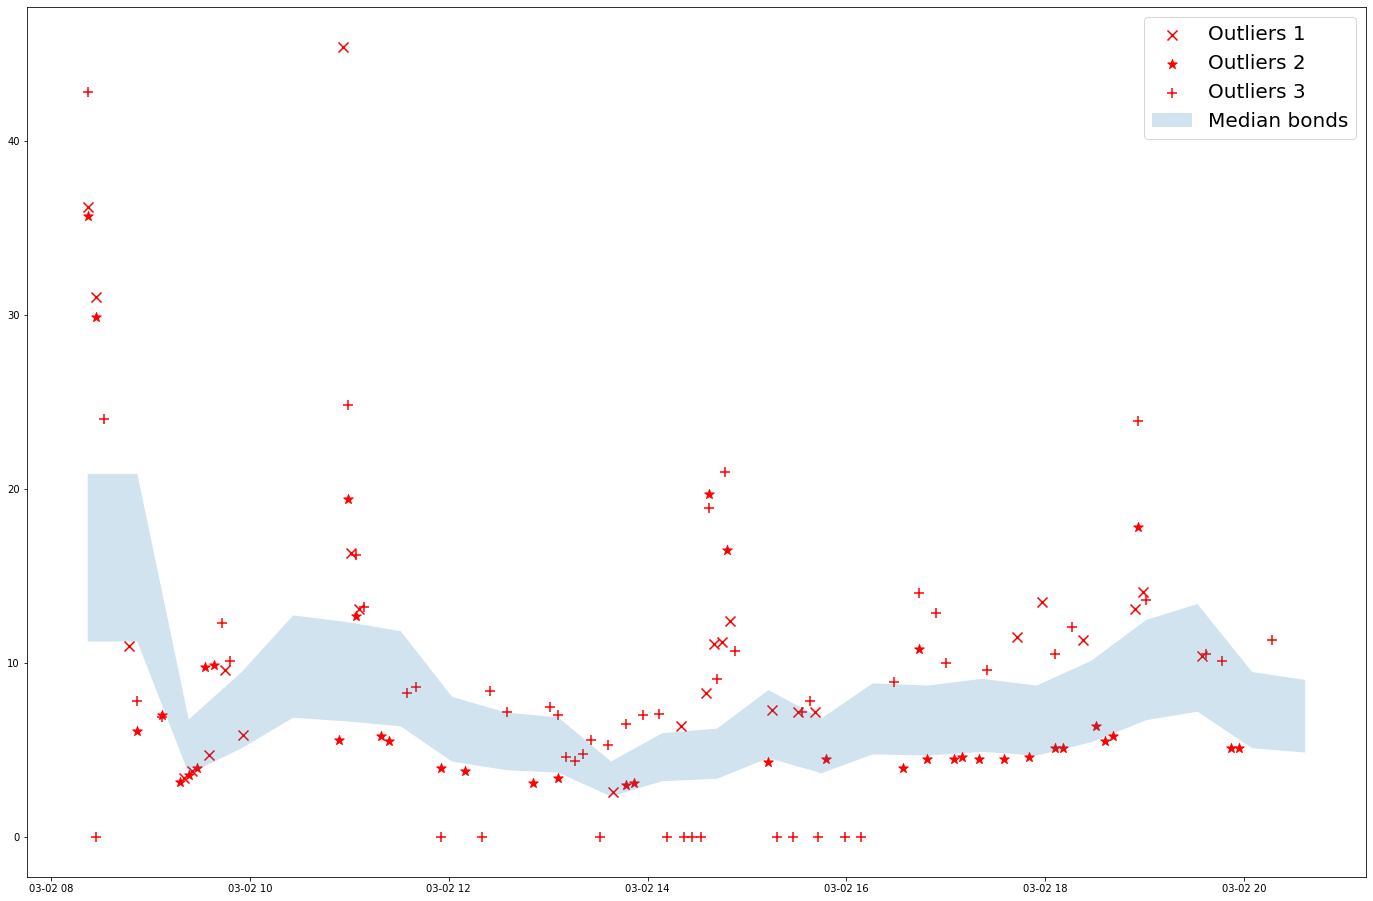

In [13]:
# Sizes of series for confidance index 
print('SmS1:',len(X1out),'errors /',len(X1raw),'points')
print('SmS2:',len(X2out),'errors /',len(X2raw),'points')
print('SmS3:',len(X3out),'errors /',len(X3raw),'points')
print('Steptime : ', tau , 'minutes')
print('Threshold', Threshold , '%')
# graphics series

plt.figure(figsize=(24,16))
plt.scatter(X1out.index, X1out.values,label='Outliers 1', s=100, c='red' ,marker = 'x')
plt.scatter(X2out.index, X2out.values,label='Outliers 2', s=100, c='red' ,marker = '*')
plt.scatter(X3out.index, X3out.values,label='Outliers 3', s=100, c='red' ,marker = '+')
# X1r.plot(label='reliable SmS1')
# X2r.plot(label='reliable SmS2')
# X3r.plot(label='reliable SmS3')
plt.fill_between(Median.index,Median['MedMax'],Median['MedMin'],alpha = 0.2, label='Median bonds')
# Outagg.plot(label='Output', linewidth = 3, c='black' )
# t=10
# plt.title('Th=50 and tau=%i' %t)
plt.legend(fontsize=20)
plt.show()

## Plotting filtered data and synthesis


SmS1: 26 errors / 141 points
SmS2: 40 errors / 142 points
SmS3: 54 errors / 142 points
Steptime :  0:30:00 minutes
Threshold 30 %


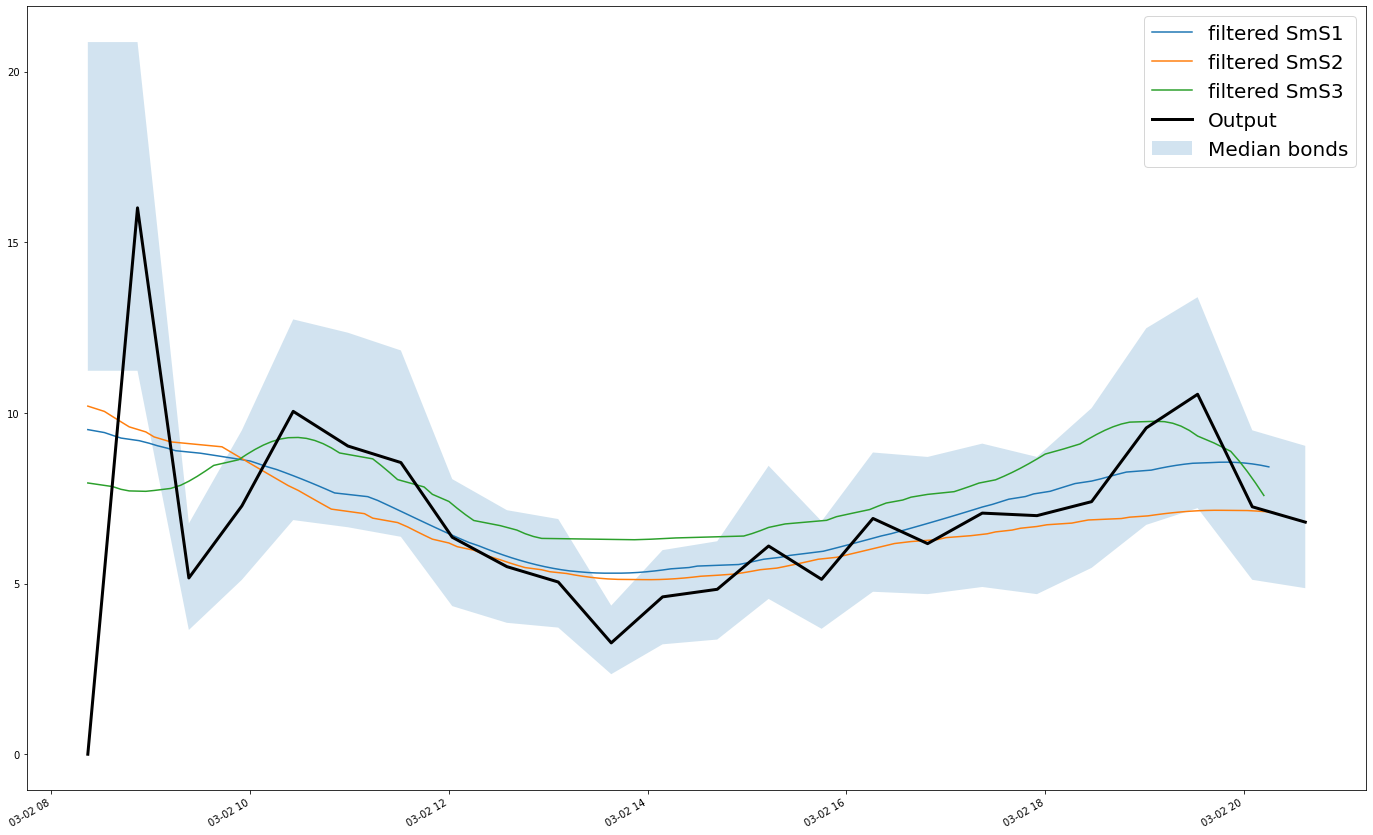

In [14]:
# Function kernel regression return filtered data (Xrf)
Xfiltered = filtering(X1r,X2r,X3r)
# Xfiltered[0],Xfiltered[1],Xfiltered[2]

# Sizes of series for confidance index 
print('SmS1:',len(X1out),'errors /',len(X1raw),'points')
print('SmS2:',len(X2out),'errors /',len(X2raw),'points')
print('SmS3:',len(X3out),'errors /',len(X3raw),'points')
print('Steptime : ', tau , 'minutes')
print('Threshold', Threshold , '%')
# graphics series

plt.figure(figsize=(24,16))
# plt.scatter(X1out.index, X1out.values,label='Outliers 1', s=100, c='red' ,marker = 'x')
# plt.scatter(X2out.index, X2out.values,label='Outliers 2', s=100, c='red' ,marker = '*')
# plt.scatter(X3out.index, X3out.values,label='Outliers 3', s=100, c='red' ,marker = '+')
Xfiltered[0].plot(label='filtered SmS1')
Xfiltered[1].plot(label='filtered SmS2')
Xfiltered[2].plot(label='filtered SmS3')
plt.fill_between(Median.index,Median['MedMax'],Median['MedMin'],alpha = 0.2, label='Median bonds')
Outagg.plot(label='Output', linewidth = 3, c='black' )
# t=10
# plt.title('Th=50 and tau=%i' %t)
plt.legend(fontsize=20)
plt.show()

Plotting synthesis + 

SmS1: 26 errors / 141 points
SmS2: 40 errors / 142 points
SmS3: 54 errors / 142 points
Steptime :  0:30:00 minutes
Threshold 30 %


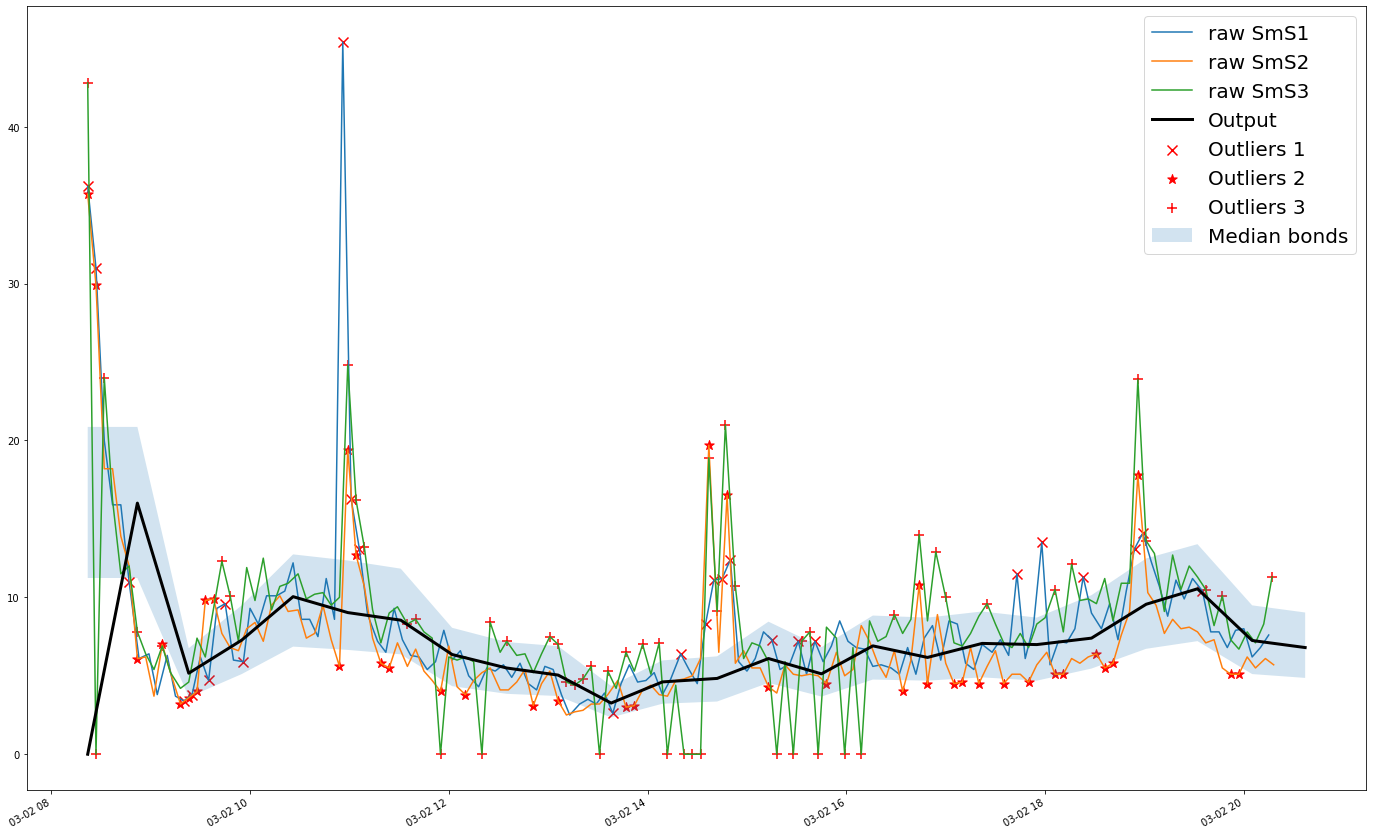

In [15]:
# Sizes of series for confidance index 
print('SmS1:',len(X1out),'errors /',len(X1raw),'points')
print('SmS2:',len(X2out),'errors /',len(X2raw),'points')
print('SmS3:',len(X3out),'errors /',len(X3raw),'points')
print('Steptime : ', tau , 'minutes')
print('Threshold', Threshold , '%')
# graphics series

plt.figure(figsize=(24,16))
plt.scatter(X1out.index, X1out.values,label='Outliers 1', s=100, c='red' ,marker = 'x')
plt.scatter(X2out.index, X2out.values,label='Outliers 2', s=100, c='red' ,marker = '*')
plt.scatter(X3out.index, X3out.values,label='Outliers 3', s=100, c='red' ,marker = '+')
X1raw.plot(label='raw SmS1')
X2raw.plot(label='raw SmS2')
X3raw.plot(label='raw SmS3')
plt.fill_between(Median.index,Median['MedMax'],Median['MedMin'],alpha = 0.2, label='Median bonds')
# plt.scatter(Median.index, Median['Median'], s=100, c='red')
Outagg.plot(label='Output', linewidth = 3, c='black' )
# t=10
# plt.title('Th=50 and tau=%i' %t)
plt.legend(fontsize=20)
plt.show()